In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from birds_utils import DataGenerator

dataset_folder_train = './dataset/train/'
dataset_folder_val = './dataset/val/'
dgen_train = DataGenerator(dataset_folder_train, batch_size=128)
dgen_val = DataGenerator(dataset_folder_val, batch_size=128)

{'amegfi': 0, 'aldfly': 1, 'amecro': 2}
{'amegfi': 0, 'aldfly': 1, 'amecro': 2}


In [4]:
len(dgen_val)/len(dgen_train)

0.26143790849673204

In [24]:
for x, c in dgen_train:
    print(x.shape, c.shape)
    break

(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(62406,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(35633,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(97768,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(11

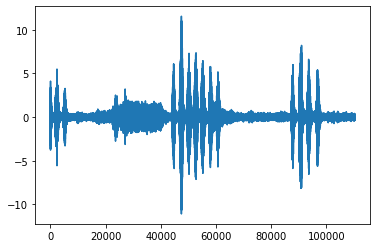

In [22]:
plt.plot(x[0][0])

In [6]:
len(dgen_train), len(dgen_val)

(153, 40)

In [7]:
# del X, y

In [8]:
def get_fourier_weights(window_size):
    frec = np.linspace(-window_size//2, window_size//2-1, window_size)
    time = np.linspace(0, window_size-1, window_size)
    hanning_window = np.hanning(window_size)

    filters_cos = []
    filters_sin = []
    for i in range(window_size//2):
        filters_cos.append(np.cos(2*np.pi*frec[i]*time/window_size))
        filters_sin.append(np.sin(2*np.pi*frec[i]*time/window_size))
    filters_cos = np.array(filters_cos)[::-1]*hanning_window
    filters_sin = np.array(filters_sin)[::-1]*hanning_window
    return filters_cos, filters_sin

def set_cnn_weights(model, filters_cos, filters_sin, cos_layer='cos', sin_layer='sin'):
    weights_cos = model.get_layer(cos_layer).get_weights()
    weights_sin = model.get_layer(sin_layer).get_weights()
    weights_cos[0] = np.array(filters_cos).T.reshape(kernel_size, 1, filters)
    weights_sin[0] = np.array(filters_sin).T.reshape(kernel_size, 1, filters)
    model.get_layer(cos_layer).set_weights(weights_cos)
    model.get_layer(sin_layer).set_weights(weights_sin)

In [9]:
from tensorflow.keras.layers import Dense, Conv1D, Input, MaxPool1D, GlobalAveragePooling1D, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

In [10]:
#model = Sequential()
window_size = 1024
kernel_size = window_size
stride = kernel_size//4
filters = kernel_size//2
inp = Input(shape=(None,1))
cos_out = Conv1D(filters, kernel_size, stride, padding='same', name = 'cos')(inp)
sin_out = Conv1D(filters, kernel_size, stride, padding='same', name = 'sin')(inp)
fourier_out = K.log(K.square(cos_out) + K.square(sin_out))
# fourier_out = Activation('relu')(cos_out) + Activation('relu')(sin_out)
gap_out = GlobalAveragePooling1D()(fourier_out)
out = Dense(3, activation='softmax')(gap_out)

#  model = Model(inp, [fourier_out, out])
model = Model(inp, out)

model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
cos (Conv1D)                    (None, None, 512)    524800      input_1[0][0]                    
__________________________________________________________________________________________________
sin (Conv1D)                    (None, None, 512)    524800      input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Square (TensorFlowO [(None, None, 512)]  0           cos[0][0]                        
______________________________________________________________________________________________

In [11]:
filters_cos, filters_sin = get_fourier_weights(window_size)
set_cnn_weights(model, filters_cos, filters_sin)

In [12]:
# model.get_layer('cos').trainable = False
# model.get_layer('sin').trainable = False

In [13]:
cbs = [
    callbacks.ModelCheckpoint('weights_2048.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True),
    # callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=10, min_lr=1e-5)
] 


In [14]:
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(dgen_train, epochs=200, validation_data=dgen_val, callbacks=cbs)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [37]:
# time = np.linspace(0, window_size-1, window_size)
# plt.figure(figsize=(30,10))
# for i in range(5):
#     plt.plot(time/sr, filters_cos[i])
# plt.figure(figsize=(30,10))
# for i in range(5):
#     plt.plot(time/sr, filters_sin[i])

In [38]:
# filters_cos, filters_sin = get_fourier_weights(window_size)
# set_cnn_weights(model, filters_cos, filters_sin)

In [39]:
model.evaluate(dgen_val)

19/19 [==============================] - 1s 39ms/step - loss: 0.6414 - accuracy: 0.7054


[0.6413843035697937, 0.7053907513618469]

In [40]:
model.load_weights('weights_2048.hdf5')
model.evaluate(dgen_val)

19/19 [==============================] - 1s 38ms/step - loss: 0.6039 - accuracy: 0.7296


[0.6038753986358643, 0.7296280860900879]

In [41]:
# 0.9569892287254333 window size 512

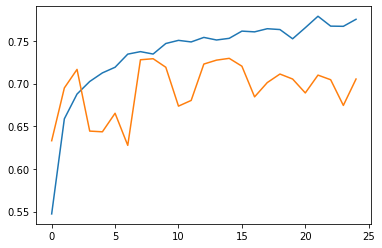

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [43]:
weights_cos = model.get_layer('cos').get_weights()[0].T.reshape(filters_cos.shape)
weights_sin = model.get_layer('sin').get_weights()[0].T.reshape(filters_sin.shape)

In [49]:
most_diff_indexes = np.argsort((weights_cos - filters_cos).var(axis=1))[::-1]

In [45]:
most_diff_indexes[:20]

array([511, 256, 254,  55, 455, 451,  59, 321, 509,   1, 189,  51, 502,
         8, 459, 102, 408,  65,   6, 170])

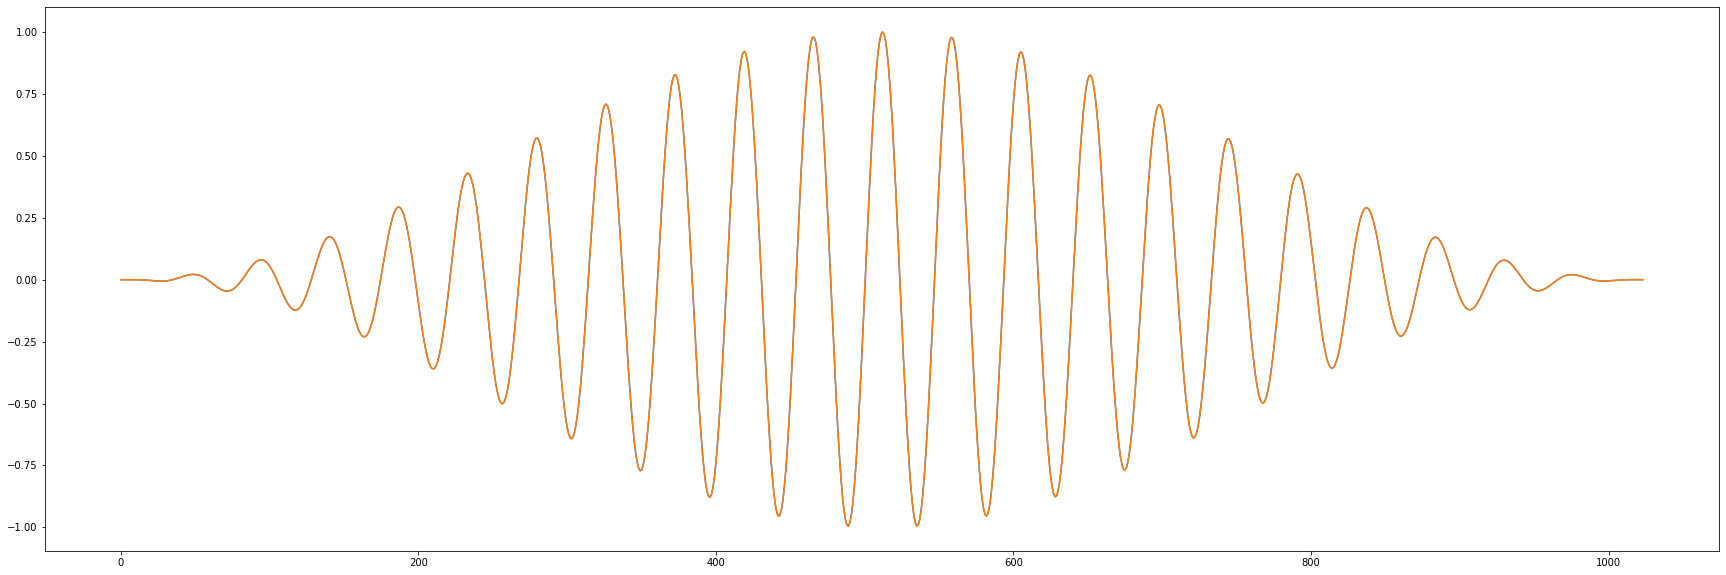

In [46]:
idx = 21
plt.figure(figsize=(30,10))
plt.plot(weights_cos[idx])
plt.plot(filters_cos[idx])

In [48]:
# x, sr, duration = get_train_clip(train[train['ebird_code']=='ameavo'].iloc[0])
# print(duration)